Create 3 sub DataFrames from the h5 file, monofil, quare, likelihood

In [ ]:
import pandas as pd
import numpy as np
h5_path = r"C:\Python_programming\LIA_LIU\GH010345_convertedDLC_DlcrnetStride32Ms5_dlcrnet_stride32_ms5_2Nov18shuffle1_snapshot_100_batchsize_2.h5"
df = pd.read_hdf(h5_path)
df.columns = [f"{bodypart}_{coord}" for bodypart, coord in zip(df.columns.get_level_values(1), df.columns.get_level_values(2))]
df_monofil = df.loc[:, df.columns.str.startswith(('FR', 'FG', 'FB')) & ~df.columns.str.endswith('likelihood')]
df_square = df.loc[:, df.columns.str.startswith(('Top_left', 'Top_right', 'Bottom_left', 'Bottom_right')) & ~df.columns.str.endswith('likelihood')]
df_likelihoods = df.loc[:, df.columns.str.endswith('likelihood')]
overall_average = df_likelihoods.mean().mean()
print("Overall Average Likelihood:", overall_average)
bodypart_means = df_likelihoods.mean(axis=0)
print("Mean likelihood for each body part:")
print(bodypart_means)


Overall Average Likelihood: 0.8845649
Mean likelihood for each body part:
FR1_likelihood             0.895894
FR2_likelihood             0.896009
FG1_likelihood             0.917550
FG2_likelihood             0.931863
FB1_likelihood             0.991343
FB2_likelihood             0.996009
Top_left_likelihood        0.938756
Top_right_likelihood       0.867348
Bottom_left_likelihood     0.681322
Bottom_right_likelihood    0.729554
dtype: float32


Fill missing values

In [3]:
df_monofil.interpolate(method='linear', inplace=True)
df_square.interpolate(method='linear', inplace=True)
print(df_monofil.isna().sum())
print(df_square.isna().sum())

FR1_x    0
FR1_y    0
FR2_x    0
FR2_y    0
FG1_x    0
FG1_y    0
FG2_x    0
FG2_y    0
FB1_x    0
FB1_y    0
FB2_x    0
FB2_y    0
dtype: int64
Top_left_x        0
Top_left_y        0
Top_right_x       0
Top_right_y       0
Bottom_left_x     0
Bottom_left_y     0
Bottom_right_x    0
Bottom_right_y    0
dtype: int64


C:\Users\sweer\AppData\Local\Temp\ipykernel_25004\293690190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monofil.interpolate(method='linear', inplace=True)
C:\Users\sweer\AppData\Local\Temp\ipykernel_25004\293690190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_square.interpolate(method='linear', inplace=True)


Create bending_coeficcient, calculate the peaks and plot

C:\Users\sweer\AppData\Local\Temp\ipykernel_25004\3343731562.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monofil["Bending_Coefficient"] = bending_coefficients


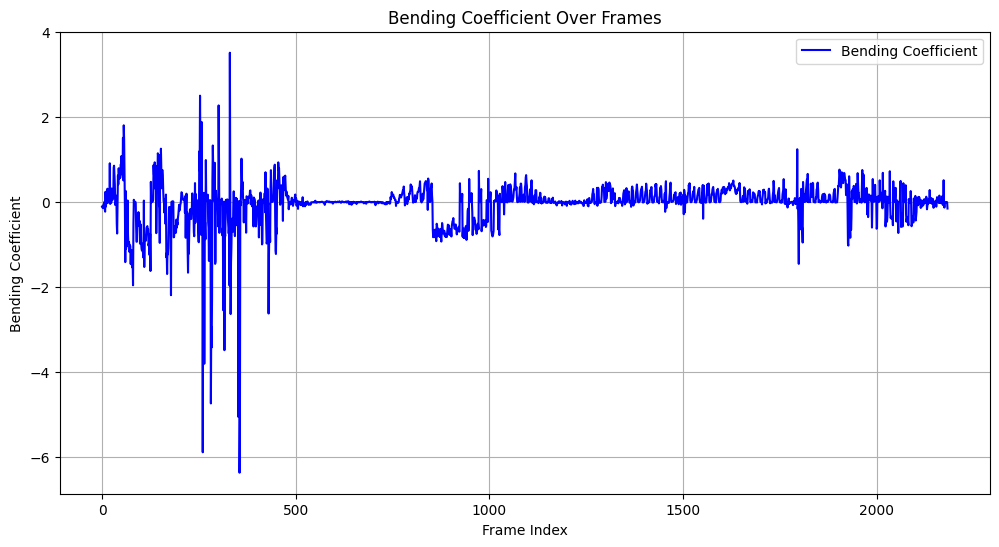

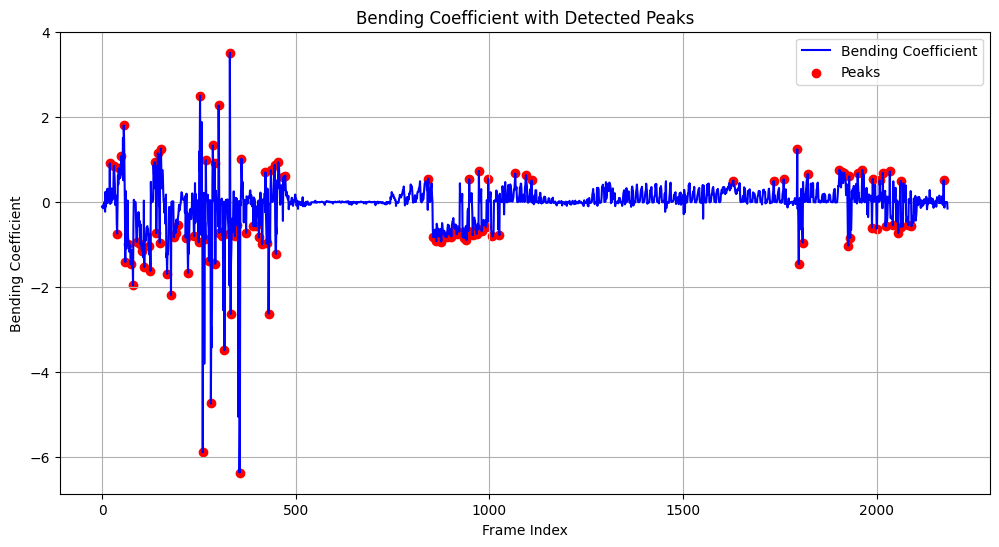

Detected Peaks:
20      0.908191
31      0.850917
39     -0.744149
43      0.790950
50      1.079148
          ...   
2062    0.491994
2063   -0.589499
2082   -0.549028
2090   -0.573328
2173    0.509855
Name: Bending_Coefficient, Length: 122, dtype: float64
Total nr of peaks: 122


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming df_monofil is already loaded with monofilament data

# Initialize a list to store bending coefficients
bending_coefficients = []

# Process each row of df_monofil
for index, row in df_monofil.iterrows():
    # Step 1: Extract x and y coordinates for the current row
    x_coords = row.filter(like="_x").values
    y_coords = row.filter(like="_y").values

    # Step 2: Center coordinates around their mean
    x_centered = x_coords - np.mean(x_coords)
    y_centered = y_coords - np.mean(y_coords)

    # Step 3: Fit a polynomial (degree 2)
    degree = 2
    coefficients = np.polyfit(x_centered, y_centered, degree)
    bending_coeff = coefficients[0]  # Coefficient of the quadratic term

    # Store the bending coefficient for this frame
    bending_coefficients.append(bending_coeff)

# Step 4: Add the bending coefficients as a new column in df_monofil
df_monofil["Bending_Coefficient"] = bending_coefficients

# Create Threshhold for peaks at 12% of the maxiumum values
max_val = df_monofil['Bending_Coefficient'].max()
threshold = 0.14 * max_val  

# Step 5: Plot the bending coefficients
plt.figure(figsize=(12, 6))
plt.plot(df_monofil.index, df_monofil["Bending_Coefficient"], label="Bending Coefficient", color="blue")
plt.title("Bending Coefficient Over Frames")
plt.xlabel("Frame Index")
plt.ylabel("Bending Coefficient")
plt.grid(True)
plt.legend()
plt.show()

# Step 6: Detect peaks in the bending coefficient column
positive_peaks, _ = find_peaks(df_monofil["Bending_Coefficient"], height=threshold, distance=5)

# For negative peaks (invert the signal)
negative_peaks, _ = find_peaks(-df_monofil['Bending_Coefficient'], height=threshold, distance=5)

# Combine both
all_peaks = np.sort(np.concatenate((positive_peaks, negative_peaks)))

# Step 7: Overlay peaks on the bending coefficient plot
plt.figure(figsize=(12, 6))
plt.plot(df_monofil.index, df_monofil["Bending_Coefficient"], label="Bending Coefficient", color="blue")
plt.scatter(all_peaks, df_monofil["Bending_Coefficient"].iloc[all_peaks], color="red", label="Peaks")
plt.title("Bending Coefficient with Detected Peaks")
plt.xlabel("Frame Index")
plt.ylabel("Bending Coefficient")
plt.grid(True)
plt.legend()
plt.show()

# Step 8: Display peak indices and values
peak_values = df_monofil["Bending_Coefficient"].iloc[all_peaks]
print("Detected Peaks:")
print(peak_values)
print(f"Total nr of peaks: {len(peak_values)}")

Read in Nerve Data

In [5]:
file_path = r"C:\Python_programming\LIA_LIU\Unit 4 Spike Sort Accel RF Map.xlsx"
df_nerve = pd.read_excel(file_path)
df_nerve.tail()

,Time,Spikes nw-1-01,16 Comments,5 Accelerometer,Unnamed: 4,Comments (1 in column C)
104141,104.141,0,0,1.781107,NaN,NaN
104142,104.142,0,0,1.781620,NaN,NaN
104143,104.143,0,0,1.782132,NaN,NaN
104144,104.144,0,0,1.782645,NaN,NaN
104145,NaN,116,4,NaN,NaN,NaN


Plot accelerometer data

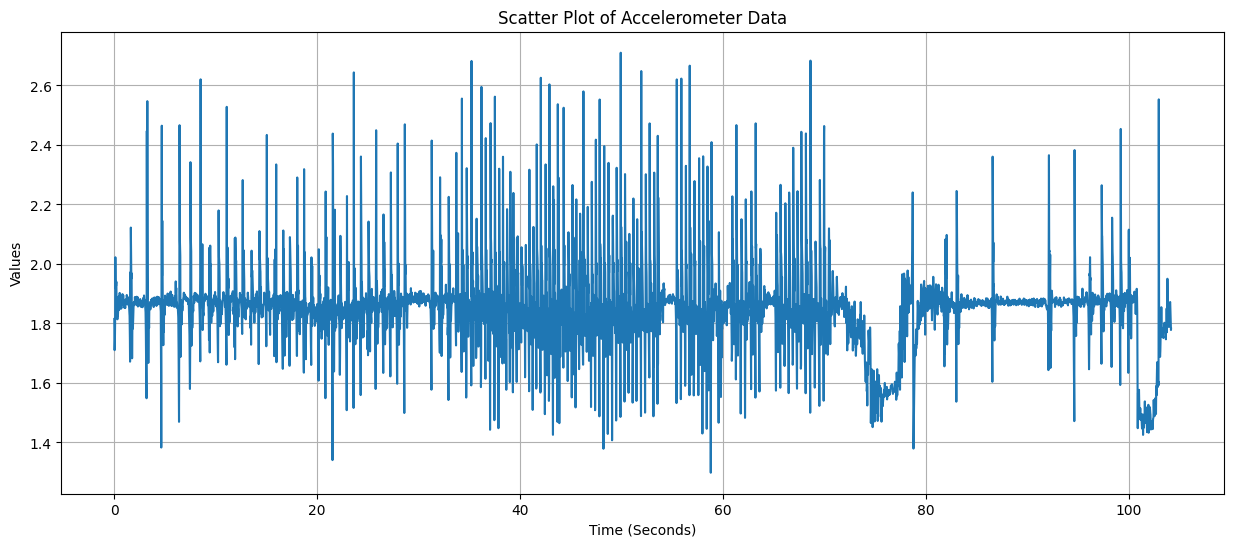

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(df_nerve["Time"], df_nerve["5 Accelerometer"])
plt.title("Scatter Plot of Accelerometer Data")
plt.xlabel("Time (Seconds)")
plt.ylabel("Values")
plt.grid(True)
#plt.xlim(0,20000)

# Show the plot
plt.show()

Create a all_peaks column for when the accelerometer spikes

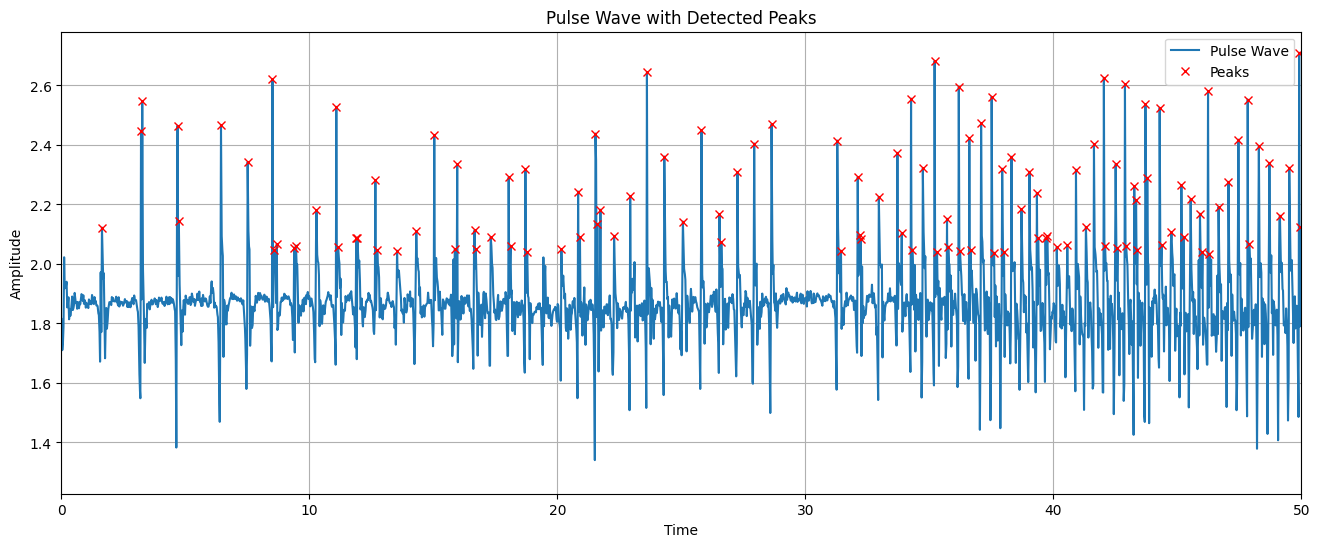

188


In [7]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

data = {
    "Time": df_nerve["Time"],  # Assuming df_nerve is your actual DataFrame with "Time" column
    "Pulse": df_nerve["5 Accelerometer"],  # The "5 Accelerometer" column for pulse data
}
df = pd.DataFrame(data)

# Create Threshhold for peaks at 12% of the maxiumum values
max_val = df_nerve['5 Accelerometer'].max()
threshold = 0.75 * max_val  

# Use find_peaks to detect peaks
positive_peaks, _ = find_peaks(df_nerve["5 Accelerometer"], height=threshold, distance=5)
# For negative peaks (invert the signal)
negative_peaks, _ = find_peaks(-df_nerve["5 Accelerometer"], height=threshold, distance=5)

# Combine both
all_peaks = np.sort(np.concatenate((positive_peaks, negative_peaks)))
# Plot the data and detected peaks
plt.figure(figsize=(16, 6))
plt.plot(df["Time"], df["Pulse"], label="Pulse Wave")
plt.plot(df["Time"].iloc[all_peaks], df["Pulse"].iloc[all_peaks], "x", label="Peaks", color="red")  # Corrected access for peaks
plt.title("Pulse Wave with Detected Peaks")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0,50)
plt.show()
print(len(all_peaks))

Plot Nerve signals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


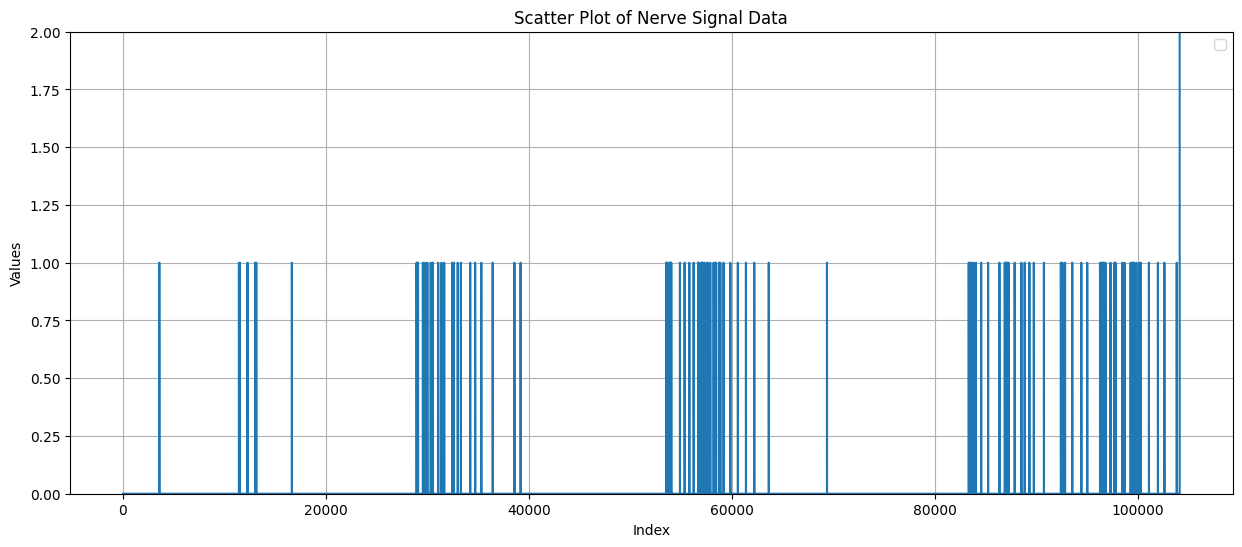

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df_nerve.index, df_nerve["Spikes nw-1-01"])
plt.title("Scatter Plot of Nerve Signal Data")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.ylim(0,2)

# Show the plot
plt.show()

In [9]:
'''
import cv2
import pandas as pd
import numpy as np

# Extract the metadata from the video, FPS and the total amount of frames
video_path = r"C:\Python_programming\LIA_LIU\GH010342_converted.mp4"
video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
video.release()

# Load your h5 file
h5_file = r"C:\Python_programming\LIA_LIU\GH010342_convertedDLC_Resnet101_test_10_000_epochsOct28shuffle1_snapshot_1425.h5"
df = pd.read_hdf(h5_file)

# Renaming columns and remove 'scorer' level
df.columns = [f"{bodypart}_{coord}" for bodypart, coord in zip(df.columns.get_level_values(1), df.columns.get_level_values(2))]

# Add 'time' column to represent timestamp in seconds
df['time'] = np.arange(len(df)) / fps

# Display the first few rows to verify
df.tail()
'''

'\nimport cv2\nimport pandas as pd\nimport numpy as np\n\n# Extract the metadata from the video, FPS and the total amount of frames\nvideo_path = r"C:\\Python_programming\\LIA_LIU\\GH010342_converted.mp4"\nvideo = cv2.VideoCapture(video_path)\nfps = video.get(cv2.CAP_PROP_FPS)\ntotal_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)\nvideo.release()\n\n# Load your h5 file\nh5_file = r"C:\\Python_programming\\LIA_LIU\\GH010342_convertedDLC_Resnet101_test_10_000_epochsOct28shuffle1_snapshot_1425.h5"\ndf = pd.read_hdf(h5_file)\n\n# Renaming columns and remove \'scorer\' level\ndf.columns = [f"{bodypart}_{coord}" for bodypart, coord in zip(df.columns.get_level_values(1), df.columns.get_level_values(2))]\n\n# Add \'time\' column to represent timestamp in seconds\ndf[\'time\'] = np.arange(len(df)) / fps\n\n# Display the first few rows to verify\ndf.tail()\n'

Extract the relevent data from the nerv file

Split DataFrame in 3 sub DF's , monofilament, square and likelihood

In [11]:
'''
# Sub-DataFrame 1: df_monofil for FR, FG, and FB columns
df_monofil = df.loc[:, df.columns.str.startswith(('FR', 'FG', 'FB'))\
                    & ~df.columns.str.endswith('likelihood')]

# Sub-DataFrame 2: df_square for Top_left, Top_right, Bottom_left, Bottom_right columns
df_square = df.loc[:, df.columns.str.startswith(('Top_left',
                                                 'Top_right',
                                                 'Bottom_left',
                                                 'Bottom_right'))\
                    & ~df.columns.str.endswith('likelihood')]

# Sub-DataFrame 3: df_likelihoods for all likelihood columns
df_likelihoods = df.loc[:, df.columns.str.endswith('likelihood')]

# Display the first few rows of each to verify
print("Monofilament DataFrame:\n", df_monofil.head())
print("\nSquare DataFrame:\n", df_square.head())
print("\nLikelihoods DataFrame:\n", df_likelihoods.head())
'''

'\n# Sub-DataFrame 1: df_monofil for FR, FG, and FB columns\ndf_monofil = df.loc[:, df.columns.str.startswith((\'FR\', \'FG\', \'FB\'))                    & ~df.columns.str.endswith(\'likelihood\')]\n\n# Sub-DataFrame 2: df_square for Top_left, Top_right, Bottom_left, Bottom_right columns\ndf_square = df.loc[:, df.columns.str.startswith((\'Top_left\',\n                                                 \'Top_right\',\n                                                 \'Bottom_left\',\n                                                 \'Bottom_right\'))                    & ~df.columns.str.endswith(\'likelihood\')]\n\n# Sub-DataFrame 3: df_likelihoods for all likelihood columns\ndf_likelihoods = df.loc[:, df.columns.str.endswith(\'likelihood\')]\n\n# Display the first few rows of each to verify\nprint("Monofilament DataFrame:\n", df_monofil.head())\nprint("\nSquare DataFrame:\n", df_square.head())\nprint("\nLikelihoods DataFrame:\n", df_likelihoods.head())\n'

In [12]:
def print_likelihood_averages(df_likelihoods):
    averages = df_likelihoods.mean()  # Calculate the mean for each column (body part)
    for body_part, avg in averages.items():
        print(f"Average likelihood for {body_part}: {avg:.4f}")
print_likelihood_averages(df_likelihoods)

Average likelihood for FR1_likelihood: 0.8959
Average likelihood for FR2_likelihood: 0.8960
Average likelihood for FG1_likelihood: 0.9175
Average likelihood for FG2_likelihood: 0.9319
Average likelihood for FB1_likelihood: 0.9913
Average likelihood for FB2_likelihood: 0.9960
Average likelihood for Top_left_likelihood: 0.9388
Average likelihood for Top_right_likelihood: 0.8673
Average likelihood for Bottom_left_likelihood: 0.6813
Average likelihood for Bottom_right_likelihood: 0.7296


In [13]:
df_square.isnull().sum()

Top_left_x        0
Top_left_y        0
Top_right_x       0
Top_right_y       0
Bottom_left_x     0
Bottom_left_y     0
Bottom_right_x    0
Bottom_right_y    0
dtype: int64

In [14]:
df_square.head()

,Top_left_x,Top_left_y,Top_right_x,Top_right_y,Bottom_left_x,Bottom_left_y,Bottom_right_x,Bottom_right_y
0,607.893005,370.872986,622.898987,301.819000,452.752991,561.775024,684.257019,228.453003
1,479.050995,462.619995,588.431030,465.640991,455.720001,563.854980,707.760986,402.803009
2,609.025024,370.217987,589.073975,466.115997,453.239014,561.559998,707.995972,401.384003
3,610.382019,369.791992,590.640015,464.601013,455.459015,563.239014,563.200012,566.288025
4,484.294006,460.196014,591.546997,463.634003,459.066010,563.254028,564.474976,565.926025


Apply homography, creates df_square_corrected nand df_monofil_corrected

In [15]:
import numpy as np
import pandas as pd
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

def apply_homography(df_monofil, df_square, segment_length_mm=20):
    """
    Applies homography transformation to the provided monofilament and square points.
    
    Parameters:
        df_monofil (pd.DataFrame): DataFrame with raw monofilament points (x, y).
        df_square (pd.DataFrame): DataFrame with raw square points (x, y).
        segment_length_mm (float): Length of the square segment in millimeters for target corners.
        
    Returns:
        pd.DataFrame: DataFrames with corrected monofilament and square points.
    """
    # Initialize variables
    trackingpoints = {}
    trackingpoints['nframes'] = df_monofil.shape[0]
    trackingpoints['nfilpoints'] = int(df_monofil.shape[1] / 2)  # each point has x, y
    trackingpoints['nsquarepoints'] = int(df_square.shape[1] / 2)  # each point has x, y

    # Prepare raw arrays for monofilament and square points
    monofilament = {'raw': np.zeros((trackingpoints['nframes'], trackingpoints['nfilpoints'], 2))}
    square = {'raw': np.zeros((trackingpoints['nframes'], trackingpoints['nsquarepoints'], 2))}

    # Populate raw arrays for monofilament and square points
    for i in range(trackingpoints['nfilpoints']):
        monofilament['raw'][:, i, :] = df_monofil.iloc[:, [i*2, i*2 + 1]].to_numpy()

    for i in range(trackingpoints['nsquarepoints']):
        square['raw'][:, i, :] = df_square.iloc[:, [i*2, i*2 + 1]].to_numpy()

    # Homography setup
    monofilament['corrected'] = np.zeros((trackingpoints['nframes'], trackingpoints['nfilpoints'], 2))
    square['corrected'] = np.zeros((trackingpoints['nframes'], trackingpoints['nsquarepoints'], 2))

    # Define target corners for square points (representing real-world dimensions)
    target_corners = {
        'x': [0, 0, segment_length_mm, segment_length_mm],
        'y': [0, segment_length_mm, 0, segment_length_mm]
    }
    target_corners_xy = np.column_stack((target_corners['x'], target_corners['y']))

    # Perform homography transformation on each frame
    for t in range(trackingpoints['nframes']):

        corners = square['raw'][t, :, :]
        filament = monofilament['raw'][t, :, :]

        # Fit projective transform (homography) using RANSAC
        model_robust, _ = ransac(
            (corners, target_corners_xy),
            ProjectiveTransform,
            min_samples=4,
            residual_threshold=2,
            max_trials=1000
        )

        # Apply the transformation to square and monofilament points
        square['corrected'][t, :, :] = model_robust(corners)
        monofilament['corrected'][t, :, :] = model_robust(filament)

    # Convert corrected points back into DataFrames with original names + "_corr"
    df_square_corrected = pd.DataFrame(
        square['corrected'].reshape(-1, trackingpoints['nsquarepoints'] * 2),
        columns=[f"{col}_corr" for col in df_square.columns]
    )

    df_monofil_corrected = pd.DataFrame(
        monofilament['corrected'].reshape(-1, trackingpoints['nfilpoints'] * 2),
        columns=[f"{col}_corr" for col in df_monofil.columns]
    )

    print("Homography transformation complete.")
    
    return df_monofil_corrected, df_square_corrected

# Call the function
df_monofil_corrected, df_square_corrected = apply_homography(df_monofil, df_square)

# Print the resulting DataFrames to check
print(df_monofil_corrected.head())
print(df_square_corrected.head())

Homography transformation complete.
   FR1_x_corr  FR1_y_corr  FR2_x_corr  FR2_y_corr  FG1_x_corr  FG1_y_corr  \
0   -1.610395    8.697412   -1.879602    9.164702   -1.890665    9.639184   
1    5.864859    0.753756    5.826240    0.832174    5.824793    0.905298   
2   -0.227053   -1.475424   -0.192289   -1.333634   -0.158186   -1.242304   
3   10.677745   -4.594941    8.578496   -4.886354    6.673463   -5.126548   
4  -41.074973   16.024821  -37.404345   16.942638  -35.503062   17.504852   

   FG2_x_corr  FG2_y_corr  FB1_x_corr  FB1_y_corr  FB2_x_corr  FB2_y_corr  
0   -2.307664    9.998222   -2.957986   10.717325   -4.425774   12.049140  
1    5.770399    0.952186    5.687447    1.028118    5.545746    1.067846  
2   -0.222189   -1.206533   -0.289262   -1.132742   -0.353250   -1.003293  
3    9.336606   -3.950709   10.289353   -3.180553   11.877289   -2.364832  
4  -32.909856   17.167849  -29.754121   16.877099  -26.090482   16.659951  
   Top_left_x_corr  Top_left_y_corr  Top_righ

Plot the coordinates from before and after homography

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tracking_results(df_monofil, df_square, df_monofil_corrected, df_square_corrected, num_frames_to_plot=10):
    """
    Plots the raw and corrected points for the square and monofilament in the specified number of frames.
    
    Parameters:
        df_monofil (DataFrame): Raw monofilament points (before homography).
        df_square (DataFrame): Raw square points (before homography).
        df_monofil_corrected (DataFrame): Corrected monofilament points (after homography).
        df_square_corrected (DataFrame): Corrected square points (after homography).
        num_frames_to_plot (int): Number of frames to display. Default is 5.
    """
    # Convert DataFrames to numpy arrays
    raw_square = df_square.to_numpy().reshape(-1, df_square.shape[1] // 2, 2)
    corrected_square = df_square_corrected.to_numpy().reshape(-1, df_square_corrected.shape[1] // 2, 2)
    raw_monofil = df_monofil.to_numpy().reshape(-1, df_monofil.shape[1] // 2, 2)
    corrected_monofil = df_monofil_corrected.to_numpy().reshape(-1, df_monofil_corrected.shape[1] // 2, 2)

    # Number of frames to plot (ensure we don't exceed available frames)
    num_frames_to_plot = min(num_frames_to_plot, raw_square.shape[0])

    # Set up the figure and axis for the plots
    fig, axes = plt.subplots(num_frames_to_plot, 2, figsize=(10, 5 * num_frames_to_plot))

    # Loop through frames
    for t in range(num_frames_to_plot):
        # Extract raw and corrected points for current frame
        raw_square_points = raw_square[t, :, :]
        corrected_square_points = corrected_square[t, :, :]
        raw_monofil_points = raw_monofil[t, :, :]
        corrected_monofil_points = corrected_monofil[t, :, :]

        # Plot raw (before homography)
        ax1 = axes[t, 0]
        ax1.scatter(raw_square_points[:, 0], raw_square_points[:, 1], color='blue', label="Square Points")
        ax1.scatter(raw_monofil_points[:, 0], raw_monofil_points[:, 1], color='red', label="Monofilament Points")
        ax1.set_title(f"Frame {t + 1} - Before Homography")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")
        ax1.legend()
        ax1.invert_yaxis()  # Invert Y to match the coordinate system
        ax1.set_xlim(300, 1200)  
        ax1.set_ylim(0, 900)

        # Plot corrected (after homography)
        ax2 = axes[t, 1]
        ax2.scatter(corrected_square_points[:, 0], corrected_square_points[:, 1], color='blue', label="Square Points")
        ax2.scatter(corrected_monofil_points[:, 0], corrected_monofil_points[:, 1], color='red', label="Monofilament Points")
        ax2.set_title(f"Frame {t + 1} - After Homography")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")
        ax2.legend()
        ax2.invert_yaxis()  # Invert Y to match the coordinate system
        ax2.set_xlim(-40, 60)  
        ax2.set_ylim(-40, 60)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()


plot_tracking_results(df_monofil, df_square, df_monofil_corrected, df_square_corrected)




Find the frames with contact using angular calculation

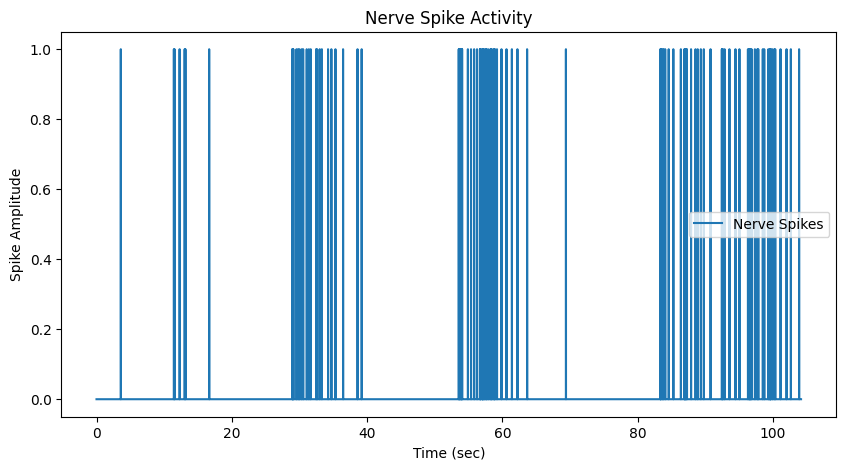

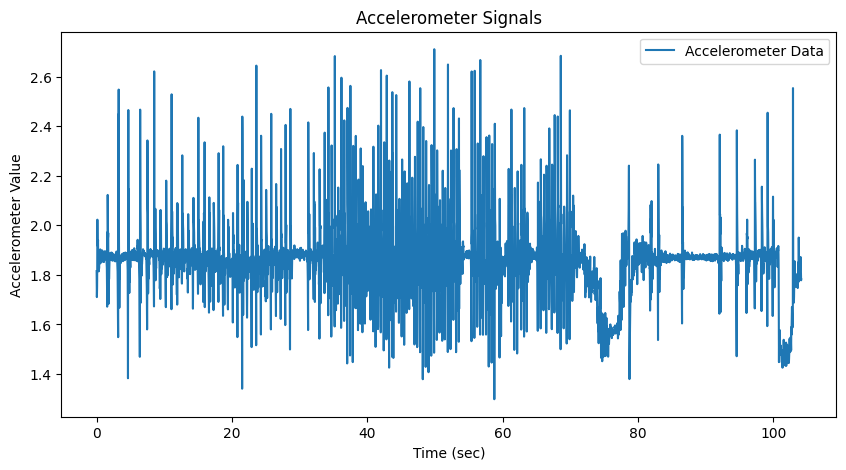

In [16]:
import pandas as pd
import numpy as np

# Clean the DataFrame
df_nerve_cleaned = df_nerve.dropna(subset=['Time', '5 Accelerometer'])  # Drop rows with missing Time or Accelerometer data

# Map to mng dictionary
mng = {
    'time_sec': df_nerve_cleaned['Time'].to_numpy(),  # Time in seconds
    'spikes': df_nerve_cleaned['Spikes nw-1-01'].to_numpy(),  # Nerve spikes
    'accelerometer': df_nerve_cleaned['5 Accelerometer'].to_numpy(),  # Accelerometer data
}

# Example: Plot spikes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(mng['time_sec'], mng['spikes'], label='Nerve Spikes')
plt.xlabel('Time (sec)')
plt.ylabel('Spike Amplitude')
plt.title('Nerve Spike Activity')
plt.legend()
plt.show()

# Example: Plot accelerometer data
plt.figure(figsize=(10, 5))
plt.plot(mng['time_sec'], mng['accelerometer'], label='Accelerometer Data')
plt.xlabel('Time (sec)')
plt.ylabel('Accelerometer Value')
plt.title('Accelerometer Signals')
plt.legend()
plt.show()

